# Analyse des données liées au COVID-19 en France
Données issues de l'Agance nationale de santé publique (Santé publique France).

## Importation des modules

In [1]:
import requests

In [2]:
from datetime import datetime
now = datetime.now()

In [3]:
import pandas as pd 

In [4]:
import numpy as np 

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Fonctions

In [6]:
# Récupération des fichiers .csv
# url = URL du fichier .csv à télécharger (str)
# file_name = nommer le fichier téléchargé (str)

def get_csv(url, file_name):
    req = requests.get(url) # Envoi de la requête

    if req.status_code == 200:
        print("LINK OK")
    else:
        print(req.status_code)

    url_content = req.content # Binary content
    csv_file = open(f'{file_name}.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()

    when = now.strftime("%d/%m/%Y à %H:%M:%S")
    print("Dernière mise à jour du CSV le", when)

    return pd.read_csv(f'{file_name}.csv', sep=";")

In [7]:
# Fonction calculant les variations de valeurs dans une série sous la forme d'un plot.bar à deux barres
# series = Prend un pandas.Series en paramètres
# mode="day" : Variation entre aujourd'hui et hier
# mode="week" : Variation entre les 7 derniers jours et les 7 précédents
# title="" : Titre du graph
# grid = False/True : Afficher ou non la grille
# absolute=True : Affiche la valeur absolue sur le graph
# absolute=False : Affiche la valeur avec l'opérateur +/- en préfixe sur le graph
# inv_color=False : La barre représantant la valeur la plus récente apparait en rouge si elle est supérieure
# inv_color=True : La barre représantant la valeur la plus récente apparait en vert si elle est supérieure  

def vario(series, mode="day", title="", grid=False, absolute=False, inv_color = False):
    if mode == "day":
        last = series[len(series)-1]
        b_last = series[len(series)-2]
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    if mode == "week":
        last_week = []
        b_last_week = []
        i = len(series)-1

        while i > (len(series)-1) - 7:
            last_week.append(series[i])
            i-=1

        while i > (len(series)-1) - 14:
            b_last_week.append(series[i])
            i-=1
        
        last = sum(last_week)
        b_last = sum(b_last_week)
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    color = ["lime", "coral"]
    if inv_color:
        color.reverse()

    if last > b_last: # Variation +
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = color

    elif last == b_last: # No variation
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["b", "b"]

    else : # Variation -
        if mode == "day":
            print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = {diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color.reverse()
    
    when = now.strftime("Le %d/%m/%Y")

    if mode == "day":
        df = pd.DataFrame({'jour':['Hier.', 'Auj.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='jour', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")
    else:
        df = pd.DataFrame({'semaine':['Sem. der.', 'Cette sem.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='semaine', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")

    x_offset = -0.1

    for p in ax.patches:
        b = p.get_bbox()
        if absolute:
            val = "{:.0f}".format(b.y1)
        else :
            val = "{:+.0f}".format(b.y1)     
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/10)))
    
    return ax

In [8]:
# Tableau détaillé
def tab(series, colname="values"):
    # series = cova_day.groupby("cl_age90").dc.sum()
    # series = cova.dc
    total = series[0]
    series = series.drop(0)
    nc = total - sum(series)
    nc_p = round((nc/total)*100, 1)

    perc = []
    i = 0
    for val in series:
        res = (val/total)*100
        res = round(res, 1)
        perc.append(res)
        i+=1
    perc.append(nc_p)
    perc.append(100)

    labels = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89", "90+", "NC", "Total"]
    values = list(series)
    values.append(nc)
    values.append(total)

    data = {"Classe d'âge": labels, colname:values, "Pourcentage":perc}

    df = pd.DataFrame(data, columns=["Classe d'âge", colname, "Pourcentage"])

    return df

## Récupération des fichiers .csv

### Données hospitalières cumulées
Données cumulées depuis le début des mesures en mars 2020.

In [9]:
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
cov = get_csv(url, "cov")

LINK OK
Dernière mise à jour du CSV le 29/11/2020 à 22:00:13


### Nouvelles données hospitalières
Variations journalières des données hospitalières

In [10]:
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
covn = get_csv(url, "covn")

LINK OK
Dernière mise à jour du CSV le 29/11/2020 à 22:00:13


### Données par classes d'âge
Données hospitalières en fonction de la classe d'âge des patients

In [11]:
url = "https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3"
cova = get_csv(url, "cova")

LINK OK
Dernière mise à jour du CSV le 29/11/2020 à 22:00:13


## Exploration des données

### Explorations des données hospitalières cumulées
cov.csv

In [12]:
# Dimensions du dataset (lignes, colonnes)
cov.shape

(77871, 7)

In [13]:
# Affichage des dernières lignes
cov.tail()

,dep,sexe,jour,hosp,rea,rad,dc
77866,974,1,2020-11-29,37,4,311,23
77867,974,2,2020-11-29,35,6,311,25
77868,976,0,2020-11-29,9,4,512,35
77869,976,1,2020-11-29,6,2,247,21
77870,976,2,2020-11-29,3,2,259,14


In [14]:
# Description générale du dataset
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77871 entries, 0 to 77870
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dep     77871 non-null  object
 1   sexe    77871 non-null  int64 
 2   jour    77871 non-null  object
 3   hosp    77871 non-null  int64 
 4   rea     77871 non-null  int64 
 5   rad     77871 non-null  int64 
 6   dc      77871 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.2+ MB


Informations sur les colonnes :

dep = Département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

sexe = 0 : h/f | 1 : h | 2 : f

jour = Date de notification

hosp = Nombre d'hospitalisations

rea = Nombre de patients en réanimation

rad = Nombre de personnes retournées à domicile

dc = Nombre de décès en milieu hospitalier


### Exploration des nouvelles données hospitalières
covn.csv

In [15]:
covn.shape

(25856, 6)

In [16]:
covn.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
25851,976,2020-11-25,2,0,0,4
25852,976,2020-11-26,1,1,0,0
25853,976,2020-11-27,2,1,0,2
25854,976,2020-11-28,0,0,0,2
25855,976,2020-11-29,0,0,0,0


In [17]:
covn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25856 entries, 0 to 25855
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dep         25856 non-null  object
 1   jour        25856 non-null  object
 2   incid_hosp  25856 non-null  int64 
 3   incid_rea   25856 non-null  int64 
 4   incid_dc    25856 non-null  int64 
 5   incid_rad   25856 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


Informations sur les colonnes :

dep = département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

jour = Date de notification

incid_hosp = Nombre quotidien de personnes nouvellement hospitalisées

incid_rea = Nombre quotidien de nouvelles admissions en réanimation

incid_dc = Nombre quotidien de personnes nouvellement décédées

incid_rad = Nombre quotidien de nouveaux retours à domicile

### Exploration des données hospitalières par classes d'âge
cova.csv

In [18]:
cova.shape

(50886, 7)

In [19]:
cova.tail()

,reg,cl_age90,jour,hosp,rea,rad,dc
50881,94,59,2020-11-29,3,2,75,5
50882,94,69,2020-11-29,10,7,80,10
50883,94,79,2020-11-29,8,0,104,27
50884,94,89,2020-11-29,15,0,82,47
50885,94,90,2020-11-29,5,0,27,19


In [20]:
cova.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50886 entries, 0 to 50885
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       50886 non-null  int64 
 1   cl_age90  50886 non-null  int64 
 2   jour      50886 non-null  object
 3   hosp      50886 non-null  int64 
 4   rea       50886 non-null  int64 
 5   rad       50886 non-null  int64 
 6   dc        50886 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.7+ MB


In [21]:
# Listage des valeurs uniques de la colonne cl_age90
cova['cl_age90'].unique()

array([ 0,  9, 19, 29, 39, 49, 59, 69, 79, 89, 90], dtype=int64)

Informations sur les colonnes :

reg = Région départementale

cl_age90 :

0 = Toutes classes d'âge confondues

9 = 0-9 ans

19 = 10-19 ans

29 = 20-29 ans

39 = 30-39 ans

49 = 40-49 ans

59 = 50-59 ans

69 = 60-69 ans

79 = 70-79 ans

89 = 80-89 ans

90 = 90+ ans

jour = Date de notification

hosp = Nombre de personnes actuellement hospitalisées

rea = Nombre de personnes actuellement en réanimation ou soins intensifs

rad = Nombre cumulé de personnes retournées à domicile

dc = Nombre cumulé de personnes décédées

## Visualisations

### Par type de cas hospitalier
### Zone : tout le territoire

### Réanimations

In [22]:
cov_0 = cov.loc[cov['sexe'] == 0]
cov_rea = cov_0.groupby("jour").rea.sum()

Variation journalière = -21 [-0.56%] (Auj. : 3744, hier : 3765)


<AxesSubplot:title={'center':'Nombres de personnes en réanimation\n ou en soins intensifs (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

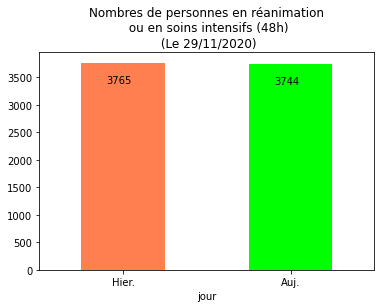

In [23]:
# Variations jour
vario(cov_rea, title="Nombres de personnes en réanimation\n ou en soins intensifs (48h)", absolute=True)

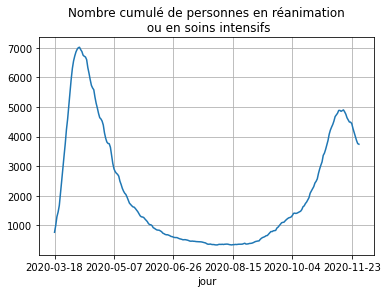

In [24]:
# Réanimations total
rea_graph = cov_rea.plot(grid=True, title="Nombre cumulé de personnes en réanimation\n ou en soins intensifs")

<AxesSubplot:title={'center':'Nombre quotidien de nouvelles admissions en réanimation'}, xlabel='jour'>

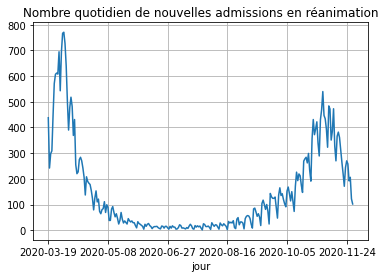

In [25]:
# Nouvelles réanimations
covn_rea = covn.groupby("jour").incid_rea.sum()
covn_rea.plot(title="Nombre quotidien de nouvelles admissions en réanimation", grid=True)

Variation journalière = -20 [-16.39%] (Auj. : 102, hier : 122)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

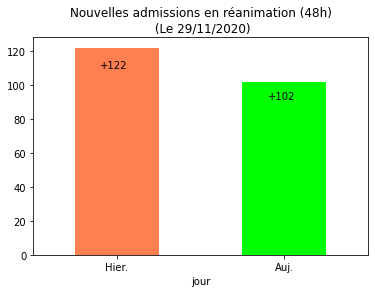

In [26]:
# Variation nouvelles admissions en réanimation
vario(covn_rea, title="Nouvelles admissions en réanimation (48h)")

Variation hébdomadaire = -681 [-32.82%] (Cette sem. : 1394, Sem. der. : 2075)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (14jr)\n (Le 29/11/2020)'}, xlabel='semaine'>

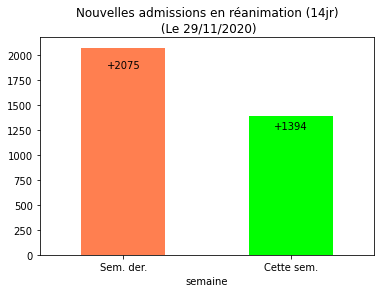

In [27]:
vario(covn_rea, title="Nouvelles admissions en réanimation (14jr)", mode="week")

### Hospitalisations

<AxesSubplot:title={'center':'Nombre cumulé de personnes hospitalisées'}, xlabel='jour'>

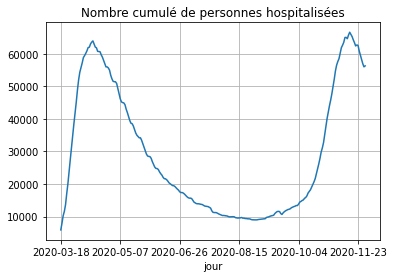

In [28]:
# Hospitalisations
cov_hosp = cov.groupby("jour").hosp.sum()
cov_hosp.plot(grid=True, title="Nombre cumulé de personnes hospitalisées")

<AxesSubplot:title={'center':'Nouvelles hospitalisations'}, xlabel='jour'>

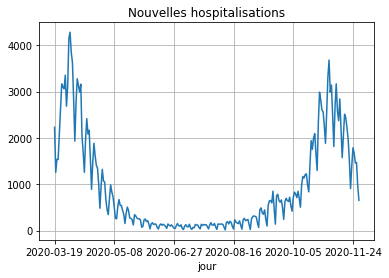

In [29]:
covn_hosp = covn.groupby("jour").incid_hosp.sum()
covn_hosp.plot(title="Nouvelles hospitalisations", grid=True)

Variation journalière = -324 [-33.2%] (Auj. : 652, hier : 976)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

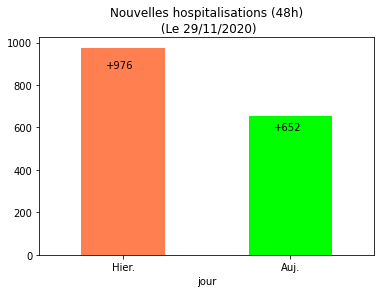

In [30]:
vario(covn_hosp, title="Nouvelles hospitalisations (48h)")

Variation hébdomadaire = -4221 [-30.98%] (Cette sem. : 9402, Sem. der. : 13623)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (14jr)\n (Le 29/11/2020)'}, xlabel='semaine'>

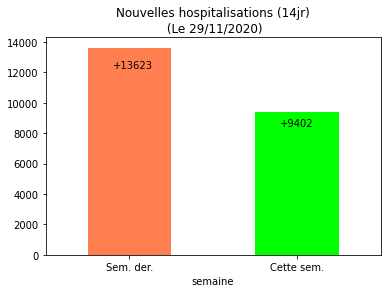

In [31]:
vario(covn_hosp, title="Nouvelles hospitalisations (14jr)", mode="week")

### Décès

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier'}, xlabel='jour'>

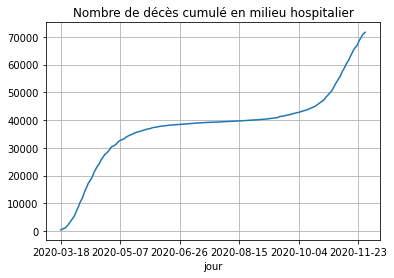

In [32]:
cov_dc = cov.groupby("jour").dc.sum()
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier")

<AxesSubplot:title={'center':'Nouveaux décès'}, xlabel='jour'>

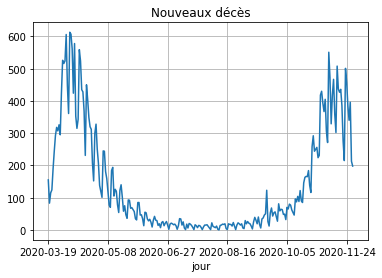

In [33]:
covn_dc = covn.groupby("jour").incid_dc.sum()
covn_dc.plot(title="Nouveaux décès", grid=True)

Variation journalière = -15 [-7.04%] (Auj. : 198, hier : 213)


<AxesSubplot:title={'center':'Nouveaux décès (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

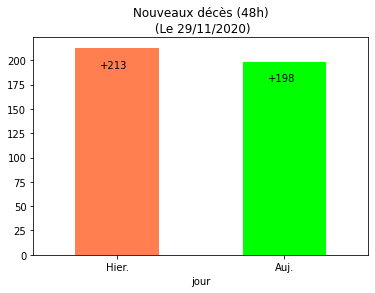

In [34]:
vario(covn_dc, title="Nouveaux décès (48h)")

Variation hébdomadaire = -196 [-7.3%] (Cette sem. : 2489, Sem. der. : 2685)


<AxesSubplot:title={'center':'Nouveaux décès (14jr)\n (Le 29/11/2020)'}, xlabel='semaine'>

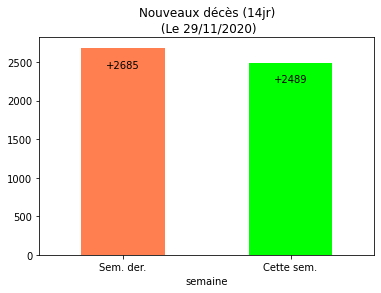

In [35]:
vario(covn_dc, mode="week", title="Nouveaux décès (14jr)")

### Retours à domicile

<AxesSubplot:title={'center':'Nouveaux retours à domicile'}, xlabel='jour'>

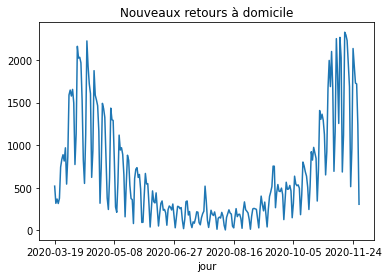

In [36]:
covn_rad = covn.groupby("jour").incid_rad.sum()
covn_rad.plot(title="Nouveaux retours à domicile")

Variation journalière = -931 [-75.26%] (Auj. : 306, hier : 1237)


<AxesSubplot:title={'center':'Retours à domicile (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

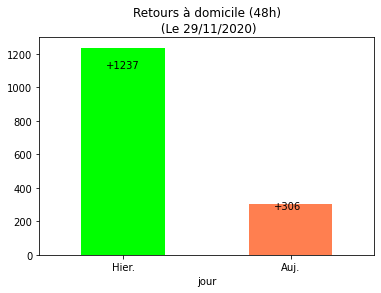

In [37]:
vario(covn_rad, title="Retours à domicile (48h)", inv_color=True)

Variation hébdomadaire = -2121 [-17.48%] (Cette sem. : 10016, Sem. der. : 12137)


<AxesSubplot:title={'center':'Retours à domicile (14jr)\n (Le 29/11/2020)'}, xlabel='semaine'>

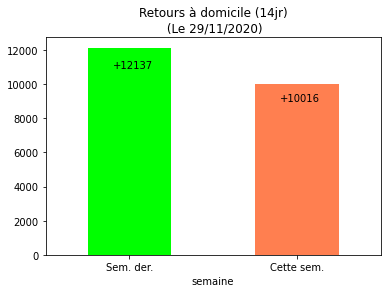

In [38]:
vario(covn_rad, title="Retours à domicile (14jr)", mode="week", inv_color=True)

### Par type de cas hospitalier
### Zone : par département

### Réanimations

In [39]:
dep = "69" # Choix du département

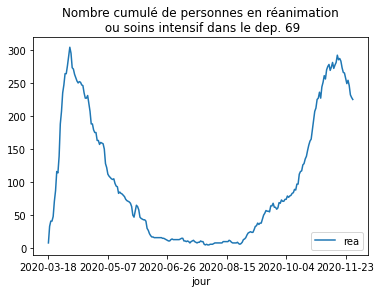

In [40]:
cov_dep = cov.loc[cov['dep'] == dep]
cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
title = f"Nombre cumulé de personnes en réanimation\n ou soins intensif dans le dep. {dep}"
rea_1 = cov_dep_0.plot(x="jour", y="rea", title=title)

<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69'}, xlabel='jour'>

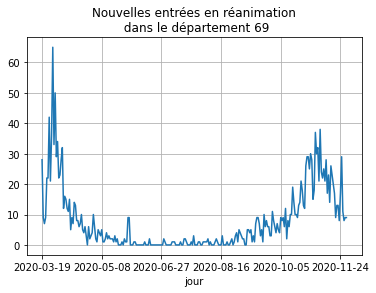

In [41]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_rea = covnDep.groupby("jour").incid_rea.sum()
covnDep_rea.plot(title=f"Nouvelles entrées en réanimation\n dans le département {dep}", grid=True)

Variation journalière = +0 [0.0%] (Auj. : 9, hier : 9)


<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69 (48h)\n (Le 29/11/2020)'}, xlabel='jour'>

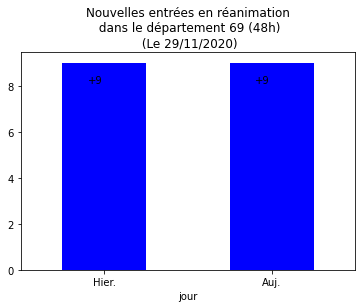

In [42]:
vario(covnDep_rea, title=f"Nouvelles entrées en réanimation\n dans le département {dep} (48h)")

Variation hébdomadaire = -30 [-24.79%] (Cette sem. : 91, Sem. der. : 121)


<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69 (14jr)\n (Le 29/11/2020)'}, xlabel='semaine'>

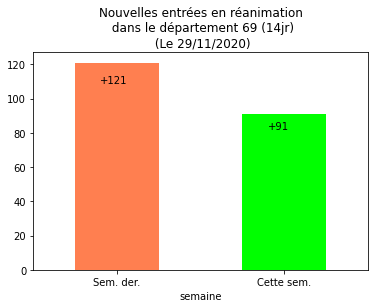

In [43]:
vario(covnDep_rea, title=f"Nouvelles entrées en réanimation\n dans le département {dep} (14jr)", mode="week")

## Par classes d'âge

### Réanimations

In [44]:
last_dt = cova['jour'].iloc[-1] # Récupération de la dernière date enregistrée du fichier .csv
cova_day = cova.loc[cova["jour"] == last_dt]
cova_rea = cova_day.groupby("cl_age90").rea.sum()
print("Personnes actuellement en réanimation par tranche d'âge")
tab(cova_rea, colname="Réanimations")

Personnes actuellement en réanimation par tranche d'âge


,Classe d'âge,Réanimations,Pourcentage
0,0-9,5,0.1
1,10-19,15,0.4
2,20-29,19,0.5
3,30-39,61,1.6
4,40-49,178,4.8
5,50-59,484,12.9
6,60-69,1180,31.5
7,70-79,1389,37.1
8,80-89,351,9.4
9,90+,32,0.9


<AxesSubplot:title={'center':"Personnes actuellement en réanimation par tranche d'âge\n(Le 29/11/2020)"}, ylabel='rea'>

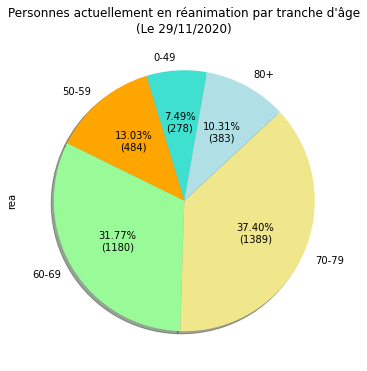

In [45]:
# Graphique
cova_rea = cova_day.groupby("cl_age90").rea.sum()
total_rea = cova_rea[0]
cova_rea = cova_rea.drop(0)
merge_1 = cova_rea[9] + cova_rea[19] + cova_rea[29] + cova_rea[39] + cova_rea[49]
# merge_1 += total_rea - sum(cova_rea) # Comptabiliser les non classés
merge_2 = cova_rea[89] + cova_rea[90]

cova_merge = cova_rea.copy()
cova_merge.loc[49] = merge_1 # Replace
cova_merge.loc[89] = merge_2 # Replace
cova_merge.drop(labels=[9,19,29,39,90], inplace=True)

labels = ["0-49","50-59","60-69","70-79","80+"]

perc = []
i = 0
for val in cova_merge:
    res = (val/total_rea)*100
    res = round(res, 1)
    perc.append(res)
    i+=1

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

colors = ["turquoise", "orange", "palegreen", "khaki", "powderblue"]
when = now.strftime("Le %d/%m/%Y")

cova_merge.plot.pie(title=f"Personnes actuellement en réanimation par tranche d'âge\n({when})", figsize=(6,6), shadow=True, startangle=80, labels=labels, colors=colors, autopct=make_autopct(cova_merge))

### Décès en milieu hospitalier

In [46]:
# Tableau détaillé
cova_dc = cova_day.groupby("cl_age90").dc.sum()
print("Nombre cumulé de décès en milieu hospitalier")
tab(cova_dc, colname="Décès cumulés")

Nombre cumulé de décès en milieu hospitalier


,Classe d'âge,Décès cumulés,Pourcentage
0,0-9,4,0.0
1,10-19,5,0.0
2,20-29,33,0.1
3,30-39,139,0.4
4,40-49,389,1.1
5,50-59,1353,3.8
6,60-69,3940,11.0
7,70-79,7922,22.1
8,80-89,14128,39.4
9,90+,7790,21.7


<AxesSubplot:title={'center':'Décès cumulés en milieu hospitalier\n(Le 29/11/2020)'}, ylabel='dc'>

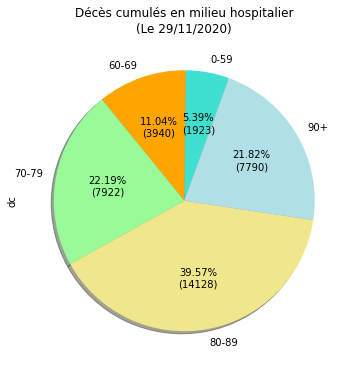

In [47]:
# Graphique
cova_dc = cova_day.groupby("cl_age90").dc.sum()
total_dc = cova_dc[0]
cova_dc = cova_dc.drop(0)
merge_1 = cova_dc[9] + cova_dc[19] + cova_dc[29] + cova_dc[39] + cova_dc[49] + cova_dc[59]
# merge_1 += total_rea - sum(cova_rea) # Comptabiliser les non classés

cova_merge = cova_dc.copy()
cova_merge.loc[59] = merge_1 # Replace
cova_merge.drop(labels=[9,19,29,39,49], inplace=True)

labels = ["0-59","60-69","70-79","80-89", "90+"]

perc = {}
i = 0
for val in cova_merge:
    res = (val/total_dc)*100
    res = round(res, 1)
    perc[labels[i]] = res
    i+=1

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

colors = ["turquoise", "orange", "palegreen", "khaki", "powderblue"]
when = now.strftime("Le %d/%m/%Y")

cova_merge.plot.pie(title=f"Décès cumulés en milieu hospitalier\n({when})", figsize=(6,6), shadow=True, startangle=70, labels=labels, colors=colors, autopct=make_autopct(cova_merge))

## Par sexe
### Réanimations

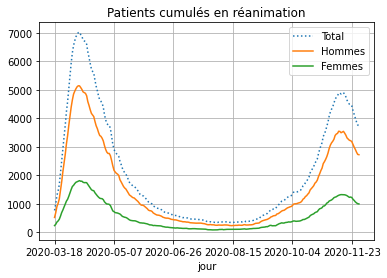

In [66]:
cov_a = cov.loc[cov['sexe'] == 0]
cov_a = cov_a.groupby("jour").rea.sum()

cov_h = cov.loc[cov['sexe'] == 1]
cov_h = cov_h.groupby("jour").rea.sum()

cov_f = cov.loc[cov['sexe'] == 2]
cov_f = cov_f.groupby("jour").rea.sum()

cov_a.plot(linestyle=':')
cov_h.plot()
graph = cov_f.plot(title="Patients cumulés en réanimation", grid=True, legend=True)
graph.legend(["Total", "Hommes", "Femmes"])